Wilson's personal notebook

Metric: Transportation

Neighborhood borders: https://data.wprdc.org/dataset/neighborhoods2
Transit stop locations: https://data.wprdc.org/dataset/port-authority-of-allegheny-county-transit-stops

In [4]:
# import libraries
import geopandas as gpd
import pandas as pd
from scipy import stats

/home/wbiggs/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [29]:
# read neighborhood polygons
neighborhoods = gpd.read_file('https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson')

# Reproject hoods to match CRS with meters as base
neighborhoods = neighborhoods.to_crs('+proj=cea +lat_0=40.440624 +lon_0=-79.995888 +units=m')

neighborhoods.head()

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,page_number,plannerassign,created_user,created_date,last_edited_user,last_edited_date,temp,Shape__Area,Shape__Length,geometry
0,1293,201,42,003,980600,1,420039806001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,1.068796e+07,19600.573085,"POLYGON ((-3795.920 4118843.009, -3785.567 411..."
1,1294,10,42,003,261200,1,420032612001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,1.133208e+07,21174.473326,"POLYGON ((-1657.274 4122282.602, -1651.679 412..."
2,1295,11,42,003,260900,1,420032609001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,8.743618e+06,13811.917169,"POLYGON ((-821.954 4120841.104, -820.083 41208..."
3,1296,7,42,003,262000,1,420032620001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,1.754935e+07,18197.745741,"POLYGON ((-192.173 4120155.314, -191.926 41201..."
4,1297,8,42,003,261500,1,420032615001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,2.522420e+07,26390.549314,"POLYGON ((-2040.634 4120396.643, -2055.439 412..."


In [31]:
# create hood buffers
hoods_buffer = neighborhoods.assign(
  old_geom = neighborhoods['geometry'],
  geometry = lambda df: df['geometry'].map(lambda geom: geom.buffer(200))
).assign(
  buffer_area = lambda df: df['geometry'].map(lambda geom: geom.area)
)

In [32]:
# read bus stop points
stops = gpd.read_file('./wbiggs-data/paac_stops_1909/PAAC_Stops_1909.dbf')

# Reproject stops to match CRS with meters as base
stops = stops.to_crs('+proj=cea +lat_0=40.440624 +lon_0=-79.995888 +units=m')

#stops.head()

In [85]:
# Count stops per neighborhood
stops_hoods_join = stops.sjoin(hoods_buffer)

hoods_points = hoods_buffer.join(stops_hoods_join.groupby('index_right').size().rename('points'),how='left')

hoods_points['points'] = hoods_points['points'].fillna(0)

hoods_points['count_per_sq_km'] = hoods_points['points'] / (hoods_points['buffer_area'] / 1000000)
hoods_points['count_per_sq_km_scaled'] = (hoods_points['count_per_sq_km'] - hoods_points['count_per_sq_km'].min()) / (hoods_points['count_per_sq_km'].max() - hoods_points['count_per_sq_km'].min())

hoods_points['buf_geom'] = hoods_points['geometry']
hoods_points['geometry'] = hoods_points['old_geom']

hoods_points

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,temp,Shape__Area,Shape__Length,geometry,old_geom,buffer_area,points,count_per_sq_km,count_per_sq_km_scaled,buf_geom
0,1293,201,42,003,980600,1,420039806001,Block Group 1,G5030,S,...,None,1.068796e+07,19600.573085,"POLYGON ((-3795.920 4118843.009, -3785.567 411...","POLYGON ((-3795.920 4118843.009, -3785.567 411...",2.297024e+06,46.0,20.025908,0.359055,"POLYGON ((-4651.036 4118991.969, -4652.711 411..."
1,1294,10,42,003,261200,1,420032612001,Block Group 1,G5030,S,...,None,1.133208e+07,21174.473326,"POLYGON ((-1657.274 4122282.602, -1651.679 412...","POLYGON ((-1657.274 4122282.602, -1651.679 412...",2.329362e+06,41.0,17.601389,0.315585,"POLYGON ((-2430.493 4121879.455, -2433.548 412..."
2,1295,11,42,003,260900,1,420032609001,Block Group 1,G5030,S,...,None,8.743618e+06,13811.917169,"POLYGON ((-821.954 4120841.104, -820.083 41208...","POLYGON ((-821.954 4120841.104, -820.083 41208...",1.757142e+06,42.0,23.902450,0.428560,"POLYGON ((-1519.229 4120299.605, -1520.042 412..."
3,1296,7,42,003,262000,1,420032620001,Block Group 1,G5030,S,...,None,1.754935e+07,18197.745741,"POLYGON ((-192.173 4120155.314, -191.926 41201...","POLYGON ((-192.173 4120155.314, -191.926 41201...",2.865198e+06,69.0,24.082106,0.431781,"POLYGON ((-854.002 4119502.753, -856.882 41195..."
4,1297,8,42,003,261500,1,420032615001,Block Group 1,G5030,S,...,None,2.522420e+07,26390.549314,"POLYGON ((-2040.634 4120396.643, -2055.439 412...","POLYGON ((-2040.634 4120396.643, -2055.439 412...",3.984973e+06,116.0,29.109355,0.521917,"POLYGON ((-3470.266 4119628.374, -3472.595 411..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,1378,251,42,003,320400,3,420033204003,Block Group 3,G5030,S,...,None,2.338689e+07,31964.844864,"POLYGON ((-49.349 4113382.307, -46.010 4113371...","POLYGON ((-49.349 4113382.307, -46.010 4113371...",4.071241e+06,32.0,7.860012,0.140926,"POLYGON ((-1489.367 4112891.319, -1489.324 411..."
86,1379,265,42,003,563000,4,420035630004,Block Group 4,G5030,S,...,None,3.683820e+06,9978.225999,"POLYGON ((-8160.301 4118959.485, -8151.727 411...","POLYGON ((-8160.301 4118959.485, -8151.727 411...",1.069505e+06,8.0,7.480096,0.134115,"POLYGON ((-9021.096 4119259.435, -9019.030 411..."
87,1380,358,42,003,562500,1,420035625001,Block Group 1,G5030,S,...,None,6.425358e+06,25260.814467,"POLYGON ((-6195.555 4119227.993, -6179.756 411...","POLYGON ((-6195.555 4119227.993, -6179.756 411...",2.498948e+06,26.0,10.404379,0.186546,"POLYGON ((-8980.134 4119317.665, -8977.098 411..."
88,1381,298,42,003,563100,3,420035631003,Block Group 3,G5030,S,...,None,1.027920e+07,16308.247349,"POLYGON ((-4276.620 4116690.947, -4269.571 411...","POLYGON ((-4276.620 4116690.947, -4269.571 411...",2.069889e+06,0.0,0.000000,0.000000,"POLYGON ((-5047.876 4116462.471, -5040.904 411..."


<AxesSubplot:>

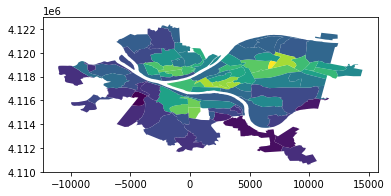

In [86]:
hoods_points.plot(column='count_per_sq_km')

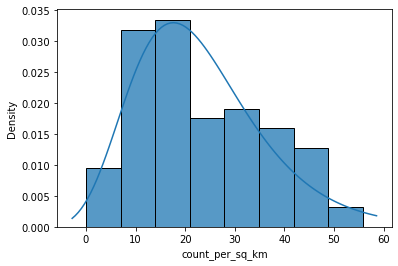

In [81]:
import seaborn as sns
import numpy as np

s, loc, scale = stats.lognorm.fit(hoods_points['count_per_sq_km'])

countplot = sns.histplot(hoods_points['count_per_sq_km'], stat='density')

space = np.linspace(*countplot.get_xlim(),100)
countplot.plot(space, stats.lognorm.pdf(space, s, loc, scale))

In [93]:
transformed = stats.lognorm.cdf(hoods_points['count_per_sq_km'], s, loc, scale)

# since we want min to be 0 and max to be 100
hoods_points['transit_score'] = (transformed - transformed.min()) / (transformed.max() - transformed.min())

pd.set_option('max_row', None)

hoods_points = hoods_points.sort_values('transit_score', ascending = False)

hoods_points[['hood', 'transit_score']]

,hood,transit_score
88,Ridgemont,0.000000
18,Hays,0.011623
20,New Homestead,0.020657
54,Swisshelm Park,0.026891
68,St. Clair,0.046634
77,Banksville,0.074141
19,Lincoln Place,0.083832
86,Chartiers City,0.086786
75,Fairywood,0.091102
89,West End,0.093492
